In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
from random import random, seed

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import sklearn.linear_model as skl

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import resample

from sklearn.preprocessing import PolynomialFeatures


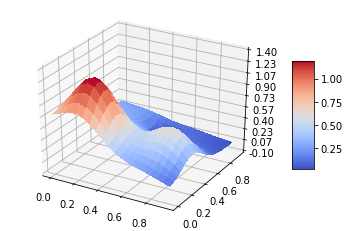

In [2]:
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [3]:
def CreateDesignMatrix_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [4]:
n_x = 250   # number of points

# sort the random values, else your fit will go crazy
#x = np.sort((np.random.uniform(0, 1, n_x)))
#y = np.sort(np.random.uniform(0, 1, n_x))

x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)

# use the meshgrid functionality, very useful
x, y = np.meshgrid(x,y)
z = FrankeFunction(x,y)

#Transform from matrices to vectors
x_1 = np.ravel(x)
y_1 = np.ravel(y)
n = int(len(x_1))
z_true = np.ravel(z)
z_1 = np.ravel(z) + np.random.normal(size=n) * 1

In [10]:
m = 10        # degree of polynomial
# finally create the design matrix
X = CreateDesignMatrix_X(x_1, y_1, n=m)

z_1 is the function that gives the data, X is the design matrix

Then inverse the matrix and find β, and perform the linear regression (where ztilde is the model):

In [11]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde = X @ beta

# For the true function (without the noise)
beta_t = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_true)
ztilde_t = X @ beta_t

def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n
print(MSE(z_true, ztilde))

def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)
print(R2(z_true, ztilde))

0.0014147510190430132
0.982847681392997


In [12]:
X_train, X_test, z_train, z_test, z_true_train, z_true_test = train_test_split(X, z_1, z_true, test_size=0.2)

# Get the new model from the training data
beta1 = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
ztilde1 = X_train @ beta1

# And the predictions for the test data
zpredict = X_test @ beta1

print("Training MSE: %0.4f" % MSE(z_train, ztilde1))
print("Test MSE: %0.4f" % MSE(z_test, zpredict))
print("True MSE: %0.4f" % MSE(z_true_test, zpredict))

print("Training R2: %0.4f" % R2(z_train, ztilde1))
print("Test R2: %0.4f" % R2(z_test, zpredict))
print("True R2: %0.4f" % R2(z_true_test, zpredict))

Training MSE: 0.9942
Test MSE: 1.0087
True MSE: 0.0014
Training R2: 0.0803
Test R2: 0.0756
True R2: 0.9834


## Complexity of model

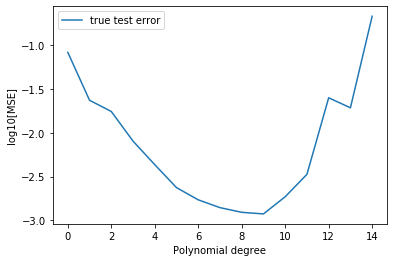

In [35]:
maxdegree = 15
true_mse = np.zeros(maxdegree)
train_mse = np.zeros(maxdegree)
polynomial = np.zeros(maxdegree)


for degree in range(maxdegree):
    X1 = CreateDesignMatrix_X(x_1, y_1, n=degree)

    X1_train, X1_test, z1_train, z1_test, z1_true_train, z1_true_test = train_test_split(X1, z_1, z_true, test_size=0.2)
    beta2 = np.linalg.inv(X1_train.T.dot(X1_train)).dot(X1_train.T).dot(z1_train)
    ztilde1 = X1_train @ beta2
    zpredict1 = X1_test @ beta2
    polynomial[degree] = degree
    true_mse[degree] = MSE(z1_true_test, zpredict1)
    #print(true_mse)
    #train_mse[degree] = MSE(z_train, ztilde1)

#print(polynomial)    
#print(true_mse)
#print(train_mse)

plt.plot(polynomial, np.log10(true_mse), label='true test error')
#plt.plot(polynomial, np.log10(train_mse), label='training error')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

#### And the bias-variance tradeoff

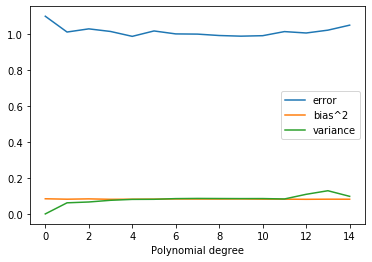

In [39]:
maxdegree = 15
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)

polynomial = np.zeros(maxdegree)

tests = 5

for degree in range(maxdegree):
    X2 = CreateDesignMatrix_X(x_1, y_1, n=degree)

    X2_train, X2_test, z2_train, z2_test, z2_true_train, z2_true_test = train_test_split(X2, z_1, z_true, test_size=0.2)
    beta3 = np.linalg.inv(X2_train.T.dot(X2_train)).dot(X2_train.T).dot(z2_train)
    ztilde2 = X2_train @ beta3
    zpredict2 = X2_test @ beta3
        
    polynomial[degree] = degree
    error[degree] = MSE(z2_test, zpredict2)    
    bias[degree] = np.mean((z2_true_test - np.mean(zpredict2))**2)   #bias for true data 
    variance[degree] = np.mean(np.var(zpredict2))

#print(polynomial)    
#print(true_mse)
#print(train_mse)

plt.plot(polynomial, error, label='error')
plt.plot(polynomial, bias, label='bias^2')
plt.plot(polynomial, variance, label='variance')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

[0.06081709518348237, 0.06703718593839723, 0.07719174993775513, 0.0815064385324055, 0.0831506999845082, 0.08456221158934094, 0.0851340092883734, 0.08562228183890161, 0.08574793420534978, 0.0865427512271374, 0.08682497183438777, 0.0873089460974295, 0.08762331754835861, 0.08808942628046708]


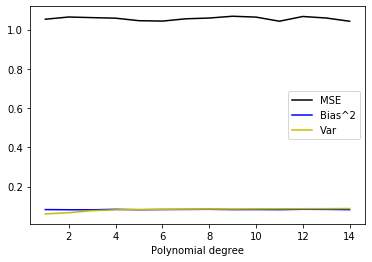

In [38]:
degrees = np.arange(1,15)

k = 5
kfold = KFold(n_splits = k, shuffle=True)

X_trainz, X_testz, y_trainz, y_testz = train_test_split(X,z_1,test_size=1./k)
array_size_thingy=len(y_testz)

z_1_ = z_1.reshape(-1,1)
z_true_ = z_true.reshape(-1,1)

error = []
bias = []
variance = []
for deg in degrees:
    z_pred = np.empty((array_size_thingy, k))
    
    j=0
    X3 = CreateDesignMatrix_X(x_1, y_1, n=deg)
    model = skl.LinearRegression(fit_intercept=False)

    for train_inds, test_inds in kfold.split(z_1):
        xtrain = X3[train_inds]
        ztrain= z_1_[train_inds]
        xtest = X3[test_inds]
        ztest = z_1_[test_inds]
        ztruetrain = z_true_[train_inds]
        ztruetest = z_true_[test_inds]
        
        z_pred[:,j] = model.fit(xtrain, ztrain).predict(xtest).ravel()
        
        j+=1

    err = np.mean(np.mean((ztest - z_pred)**2))
    bi = np.mean((ztruetest - np.mean(z_pred))**2)
    var = np.mean(np.var(z_pred))
    
    error.append(err)
    bias.append(bi)
    variance.append(var)

print(variance)
max_pd = 15 #max polynomial degree to plot to

plt.figure()
plt.plot(degrees[:max_pd],error[:max_pd],'k',label='MSE')
plt.plot(degrees[:max_pd],bias[:max_pd],'b',label='Bias^2')
plt.plot(degrees[:max_pd],variance[:max_pd],'y',label='Var')
"""summ=np.zeros(len(variance))
for i in range(len(error)):
    summ[i]=variance[i]+bias[i]
plt.plot(degrees[:max_pd],summ[:max_pd],'ro',label='sum')"""

plt.xlabel('Polynomial degree')
#plt.ylabel('MSE CV')
plt.legend()
plt.show()

## Plot of the data

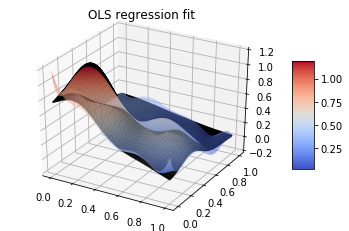

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_zlim3d(-0.2, 1.2)

#"""
ax1.scatter(x, y, z, 
           alpha=0.5, 
           s=0.1, 
           color='black'
           )
"""
ax1.scatter(x, y, z_1.reshape(x.shape), 
           alpha=0.5, 
           s=0.1, 
           color='black'
           )
"""
ax1.plot_surface(x, y, ztilde.reshape(x.shape), 
                alpha=0.5, 
                cmap=cm.coolwarm,
                )
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title(f'OLS regression fit')
plt.show()

Find the confidence intervals of the parameters β by computing their variances: 
?????

In [14]:
np.var(beta)

1769525.876231952

Next we evaluate the Mean Squared error (MSE) and the R2 score function for the model (ztilde). We evaluate it with the real FrankeFunction, the one without the noise. 

The MSE is ideally zero, since the smaller the value the better the fit. Here we observe an MSE of 0.09, which is pretty low, therefore indicating a good fit of the model.

The R2 score gives the coefficient of determination, which indicates how well the model predicts future samples. The best score would be 1.0. Given that the model has a score of 0.5 , this indicates that the model would explain 50% of the future samples correct, which is quite low (not sure if we can say this though).

## K-fold cross validation

In [9]:
# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k, shuffle=True)

In [44]:
def cross_validation(x, y, k):
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_test = []
    mse_train = []
    mse_test = []
    
    bias = []
    variance = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_train.append(MSE(y_train, ytilde))
        mse_test.append(MSE(y_test, ypredict))
        r2_test.append(R2(y_test, ypredict))
        
        bias.append(np.mean((y_test - np.mean(ypredict))**2))
        variance.append(np.mean(np.var(ypredict)))
    
    r2_test = np.array(r2_test)
    mse_train = np.array(mse_train)
    mse_test = np.array(mse_test)
    
    bias = np.array(bias)
    variance = np.array(variance)
    #print("R2-Score: %0.3f (+/- %0.3f)" % (r2_test.mean(), r2_test.std() * 2))
    #print("MSE-Score: %0.5f (+/- %0.5f)" % (mse_test.mean(), mse_test.std() * 2))
        
    return r2_test, mse_train, mse_test, bias, variance

In [24]:
r, m_train, m_test, b, v = cross_validation(X, z_true, k)

In [25]:
print(m_test)

[9.04782348e-05 8.79014148e-05 9.58415575e-05 8.99504383e-05
 9.37782312e-05 8.82616339e-05 9.60591896e-05 9.75485982e-05
 9.60325042e-05 9.69989645e-05]


Perform the sk-learn cross-validation to estimate R2 and MSE

In [15]:
linreg = skl.LinearRegression()
linreg.fit(X_train, z_train)

predictions = linreg.predict(X_test)

In [16]:
cv_scores_test = cross_val_score(linreg, X_test, z_test, cv = kfold)
print(cv_scores_test)

cv_scores_true = cross_val_score(linreg, X_test, z_true_test, cv = kfold)
print(cv_scores_true)

[0.0529166  0.08723252 0.07757997 0.09767266 0.06323452 0.08040287
 0.07560239 0.07718478 0.06743015 0.05228061]
[0.99902949 0.99880483 0.99874696 0.99891046 0.99887669 0.99884966
 0.99880151 0.9989401  0.99870165 0.99884219]


In [17]:
print("R2-Score noisy data: %0.2f (+/- %0.2f)" % (cv_scores_test.mean(), cv_scores_test.std() * 2))
print("R2-Score real data: %0.2f (+/- %0.2f)" % (cv_scores_true.mean(), cv_scores_true.std() * 2))

R2-Score noisy data: 0.07 (+/- 0.03)
R2-Score real data: 1.00 (+/- 0.00)


In [18]:
cv_scores_mse_test = cross_val_score(linreg, X_test, z_test, scoring='neg_mean_squared_error', cv=kfold)
cv_scores_mse_true = cross_val_score(linreg, X_test, z_true_test, scoring='neg_mean_squared_error', cv=kfold)

In [19]:
cv_mse_test = np.mean(-cv_scores_mse_test)
cv_mse_true = np.mean(-cv_scores_mse_true)

print('MSE-score noisy data:', cv_mse_test)
print('MSE-score real data:', cv_mse_true)

MSE-score noisy data: 1.0244134084067433
MSE-score real data: 9.380948149651986e-05


The R2-score and MSE are better for the real data then for the test data, which shows that the model does not predict the noise but the data, which is positive

#### And now the complexity with cross-validation

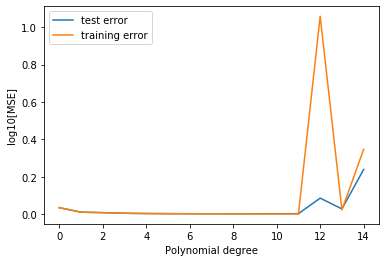

In [43]:
# train and test error

maxdegree = 15
test_mse = np.zeros(maxdegree)
train_mse = np.zeros(maxdegree)
polynomial = np.zeros(maxdegree)

for degree in range(maxdegree):
    X1 = CreateDesignMatrix_X(x_1, y_1, n=degree)
        
    polynomial[degree] = degree
    train_mse[degree] = np.mean(cross_validation(X1, z_1, k)[1])
    test_mse[degree] = np.mean(cross_validation(X1, z_1, k)[2])

plt.plot(polynomial, np.log10(test_mse), label='test error')
plt.plot(polynomial, np.log10(train_mse), label='training error')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

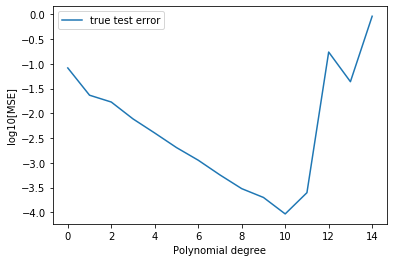

In [35]:
# for the true data

maxdegree = 15
true_mse = np.zeros(maxdegree)
train_mse = np.zeros(maxdegree)
polynomial = np.zeros(maxdegree)

for degree in range(maxdegree):
    X1 = CreateDesignMatrix_X(x_1, y_1, n=degree)
        
    polynomial[degree] = degree
    true_mse[degree] = np.mean(cross_validation(X1, z_true, k)[2])
    #print(true_mse)
    #train_mse[degree] = MSE(z_train, ztilde1)

#print(true_mse)

#print(polynomial)    
#print(true_mse)
#print(train_mse)

plt.plot(polynomial, np.log10(true_mse), label='true test error')
#plt.plot(polynomial, np.log10(train_mse), label='training error')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

### And the bias-variance tradeoff with CV

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[0.00000000e+00 2.32370270e-02 1.69165561e-02 7.72261478e-03
 4.00433696e-03 2.03580909e-03 1.13145366e-03 5.70643291e-04
 3.01781960e-04 2.00304326e-04 9.32975832e-05 1.74304569e-04
 2.20439313e-02 5.13469206e+00 7.01885175e-01]
[0.         0.08246914 0.08244732 0.082471   0.08247347 0.08247178
 0.08244726 0.08246619 0.08246633 0.08246673 0.08247179 0.08247778
 0.12807089 0.09050516 0.08652818]
[0.         0.05923868 0.06556552 0.07474891 0.07847279 0.0804379
 0.08133691 0.08189234 0.08216664 0.08227435 0.08235349 0.0829095
 0.08668444 0.11612565 0.14469554]


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


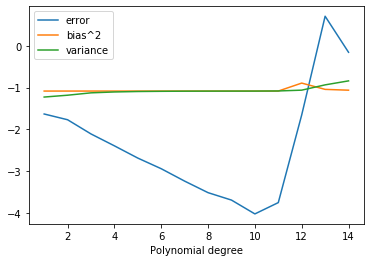

In [46]:
maxdegree = 15
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)

polynomial = np.zeros(maxdegree)


for degree in range(1, maxdegree):
    X2 = CreateDesignMatrix_X(x_1, y_1, n=degree)
        
    polynomial[degree] = degree
    error[degree] = np.mean(cross_validation(X2, z_true, k)[2])
    bias[degree] = np.mean(cross_validation(X2, z_true, k)[3])
    variance[degree] = np.mean(cross_validation(X2, z_true, k)[4])

print(polynomial)    
print(error)
print(bias)
print(variance)

plt.plot(polynomial, np.log10(error), label='error')
plt.plot(polynomial, np.log10(bias), label='bias^2')
plt.plot(polynomial, np.log10(variance), label='variance')
plt.xlabel('Polynomial degree')
plt.ylabel('log10')
plt.legend()
plt.show()

# Part D) Ridge Regression on the Franke function with resampling

First remove the first column (the intercept) so that this one is not penalised by lambda (???) You don't need to remove the intercept column for this project. Normally, if you remove the intercept column you also have to take the mean blabla something

In [18]:
_lambda = 10e-7

In [20]:
betaridge = np.linalg.inv(X_train.T.dot(X_train)+(_lambda*np.eye(len(X_train[0])))).dot(X_train.T).dot(z_train)
zridge = X_train @ betaridge

ridge_predict = X_test @ betaridge

In [43]:
print("var(beta) OLS:", np.var(beta1))
print("var(beta) ridge:", np.var(betaridge))

var(beta) OLS: 1712842.2028832515
var(beta) ridge: 104611.1482027352


In [44]:
print("MSE OLS:", MSE(z_true_test, zpredict))
print("MSE ridge:", MSE(z_true_test, ridge_predict))

MSE OLS: 0.0010715509106914984
MSE ridge: 0.001170079785039401


In [45]:
print("R2 OLS:", R2(z_true_test, zpredict))
print("R2 Ridge:", R2(z_true_test, ridge_predict))

R2 OLS: 0.9870032605891982
R2 Ridge: 0.9858081889457019


The ridge regression for different lambdas, to find out which lambda is best

In [42]:
nlambdas = 500
lambdas = np.logspace(-10, 2, nlambdas)

k = 10
kfold = KFold(n_splits = k, shuffle=True)

mse_scores_KFold = np.zeros((nlambdas, k))
r2_scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    betaridge1 = np.linalg.inv(X_train.T.dot(X_train)+(lmb*np.eye(len(X_train[0])))).dot(X_train.T).dot(z_train)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        Xtrain_r = X[train_inds]
        ztrain_r = z_true[train_inds]

        Xtest_r = X[test_inds]
        ztest_r = z_true[test_inds]
        
        zpred_r = Xtest_r @ betaridge1

        mse_scores_KFold[i,j] = np.sum((zpred_r - ztest_r)**2)/np.size(zpred_r)

        j += 1
    i += 1

estimated_mse_KFold = np.mean(mse_scores_KFold, axis = 1)

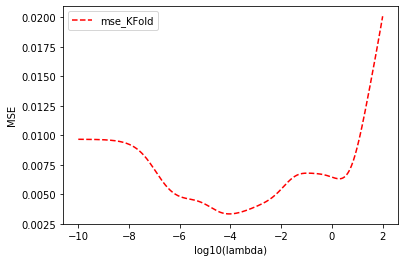

In [43]:
plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'mse_KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

The same with sklearn and GridSearchCV. 
sklearn automatically splits the data (because of the CV) so put in the whole dataset here, and not the train data! it tests on the noisy data though, that's where the difference comes from. The negative MSE means that it is just the other side of the MSE so you can 'ignore' the minus sign

In [44]:
param_grid = {'alpha': lambdas}

ridge = skl.Ridge()

ridge_regressor = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=kfold)
ridge_regressor.fit(X, z_1)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 2.709353865732049e-07}
-1.005232042923941


In [44]:
nlambdas = 500
lambdas = np.logspace(-7, 2, nlambdas)

k = 10
kfold = KFold(n_splits = k, shuffle=True)

estimated_mse_sklearn = np.zeros(nlambdas)

i = 0
for lmb in lambdas:
    ridge = skl.Ridge(alpha = lmb)

    estimated_mse_folds = cross_val_score(ridge, X, z_true, scoring='neg_mean_squared_error', cv=kfold)
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
    i += 1

print(np.mean(estimated_mse_sklearn))

0.002829989259305698


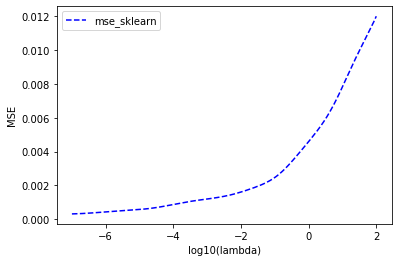

In [45]:
plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn, 'b--', label = 'mse_sklearn')
#plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'mse_KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Ridge as function of model complexity

Dit is wel nog zonder resampling nu... 

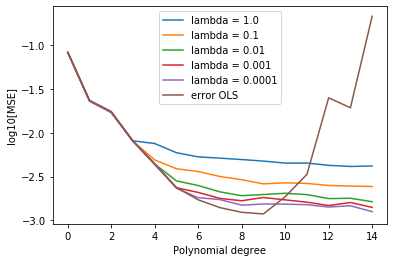

In [36]:
maxdegree = 15
polynomial = np.arange(maxdegree)


_lambdas = [1.0, 0.1, 0.01, 0.001, 0.0001]


true_mse_ridge = np.zeros((maxdegree, len(_lambdas)))

for degree in range(maxdegree):
    XR = CreateDesignMatrix_X(x_1, y_1, n=degree)

    XR_train, XR_test, zR_train, zR_test, zR_true_train, zR_true_test = train_test_split(XR, z_1, z_true, test_size=0.2)
    
    #true_mse_ridge = []
    for i in range(len(_lambdas)):
        betaridge_ = np.linalg.inv(XR_train.T.dot(XR_train)+(_lambdas[i]*np.eye(len(XR_train[0])))).dot(XR_train.T).dot(zR_train)
        ridge_predict = XR_test @ betaridge_
        true_mse_ridge[degree, i] = MSE(zR_true_test, ridge_predict)

for i in range(len(_lambdas)):
    plt.plot(polynomial, np.log10(true_mse_ridge[:,i]), label='lambda = {}'.format(_lambdas[i]))

plt.plot(polynomial, np.log10(true_mse), label='error OLS')    #the matrix probably gets near-singular for a higher complexity, which is why the OLS error goes up real fast. we can try the SVD
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()   

Bias-variance and ridge

# Part E) Lasso Regression on the Franke function with resampling


Start by finding the optimal value for lambda for lasso, using GridSearchCV

In [46]:
nlambdas = 500
lambdas_lasso = np.logspace(-7, 2, nlambdas)
param_grid_lasso = {'alpha': lambdas_lasso}

lasso = skl.Lasso(precompute = True, tol = 10, max_iter = 10e3)

lasso_regressor = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=10)
lasso_regressor.fit(X, z_1)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 1e-07}
-1.019144618365138


The optimal value for lambda is around 3.2^-4. If we use this value for lambda we can compare the MSE and R2 scores for all three models

0.04442771403508364


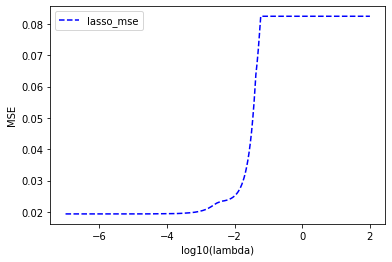

In [8]:
nlambdas = 500
lambdas = np.logspace(-7, 2, nlambdas)

k = 10
kfold = KFold(n_splits = k, shuffle=True)

lasso_mse = np.zeros(nlambdas)

i = 0
for lmb in lambdas:
    lasso = skl.Lasso(alpha = lmb, precompute = True, tol = 10, max_iter = 10e3)

    lasso_mse_folds = cross_val_score(lasso, X, z_true, scoring='neg_mean_squared_error', cv=kfold)
    lasso_mse[i] = np.mean(-lasso_mse_folds)
    i += 1

print(np.mean(lasso_mse))

plt.figure()
plt.plot(np.log10(lambdas), lasso_mse, 'b--', label = 'lasso_mse')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [46]:
l_lambda = 10e-7

clf_lasso = skl.Lasso(alpha=l_lambda, precompute = True, tol = 10, max_iter = 10e3).fit(X_train, z_train)
pred_lasso = clf_lasso.predict(X_test)

In [47]:
print("MSE OLS:", MSE(z_true_test, zpredict))
print("MSE ridge:", MSE(z_true_test, ridge_predict))
print("MSE lasso:", MSE(z_true_test, pred_lasso))

MSE OLS: 0.0010715509106914984
MSE ridge: 0.001170079785039401
MSE lasso: 0.01970005923480143


In [48]:
print("R2 OLS:", R2(z_true_test, zpredict))
print("R2 Ridge:", R2(z_true_test, ridge_predict))
print("R2 lasso:", R2(z_true_test, pred_lasso))

R2 OLS: 0.9870032605891982
R2 Ridge: 0.9858081889457019
R2 lasso: 0.7610594701368122


### Bootstrapping